<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 2.0 MB/s 


In [4]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [5]:
genes.head()

,sym,chrom
rownames,,
1000_at,MAPK3,16
1001_at,TIE1,1
1002_f_at,CYP2C19,10
1003_s_at,CXCR5,11
1004_at,CXCR5,11


A.C. cortex


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


cerebellum


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D.L.P.F. cortex


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


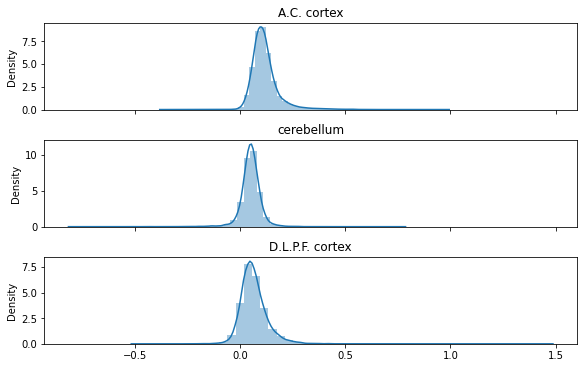

In [28]:
express_samp = pd.concat([expression, samples], axis=1)

# for each gene, need to output three numbers. One for each tissue, which summarizes the difference between average male expression and average female expression
# the genes are the columns. For each gene we need three numbers one for each tissue. Select Michigan, Select, Tissue, Select Male, avearge for each gene. 
# Select Michigan, Select Tissue, Select Female, average for each gene. 

express_samp.head()
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True, sharex='all')
express_samp_UM = express_samp[express_samp.lab == "Michigan"]
# print(express_samp_UM.head())
c = 0
for tissue in express_samp_UM["region"].unique():
  print(tissue)
  df_male = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "male")]
  df_female = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "female")]

  male_mean = expression.loc[df_male.index].mean()
  female_mean = expression.loc[df_female.index].mean()

  diff = male_mean - female_mean
  sns.histplot(diff, ax = axs[c])
  axs[c].set_title(tissue)
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  # print(top_10)
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  # print(op_genes)
  # print("")
  c += 1





In [14]:
genes.loc["31525_s_at"]

sym         NaN
chrom    16hba1
Name: 31525_s_at, dtype: object

In [8]:
express_samp.head()
express_samp_Ir = express_samp[express_samp.lab == "Irvine"]
# print(express_samp_UM.head())
for tissue in express_samp_Ir["region"].unique():
  print(tissue)
  df_male = express_samp_Ir[(express_samp_Ir.region == tissue) & (express_samp_Ir.sex == "male")]
  df_female = express_samp_Ir[(express_samp_Ir.region == tissue) & (express_samp_Ir.sex == "female")]

  male_mean = expression.loc[df_male.index].mean()
  female_mean = expression.loc[df_female.index].mean()

  diff = np.abs(male_mean - female_mean)
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values

  print(op_genes)
  print("")

A.C. cortex
['RPS4Y1', 'PLP1', 'ACTB', 'ENPP2', 'MOBP', 'ACTB', 'MARCKSL1', 'GAPDH', 'ACTB', 'TF']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
['HBB', 'HBB', 'PLP1', NaN, 'GFAP', 'SPP1', 'CRYAB', 'TF', 'MBP', 'RPS4Y1']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
['RPS4Y1', 'CALM1', 'KDM5D', 'CRYM', 'DDX3Y', 'SST', 'GAPDH', 'GAD1', NaN, 'DPP6']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

